In [1]:
import copy
import time
import gc
import os
import sys
import torch
import subprocess
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision.models import vit_b_16
from torch.utils.data import DataLoader

In [2]:
# Custom imports assuming they are in the parent directory
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)
from data_utils import ContDataset, Transform
from models import Decoder, MaskedAutoEncoder
from losses import contrastive_loss, dice_loss
from metrics import pixel_wise_accuracy, evaluate_model_performance
from data_augmentation import DataAugmentation
from utils import test_visualization

In [3]:
# Configuration for datasets
batch_size = 64
dataset_config = {
    'image_size': (224, 224),
    'data_path': '../datasets/data',
    'aug_data_path': '../datasets/aug_data'
}

pre_train = {
    'num_samples': 8000, # Size of the pre-trained dataset
    'epochs': 10,  # Total epochs for pre-training
    'learning_rate': 1e-3 # Learning rate in the pre-training phase
}

# Split configurations for fine-tuning
fine_tune_dataset_split = {
    'train_ratio': 0.8,  # Fine-tuning the scale of the training dataset
    'test_ratio': 0.2, #Fine-tuning the scale of the test dataset
}

# Training configuration for fine-tuning
fine_tune_training_config = {
    'batch_size': 64, 
    'shuffle_train': True,  
    'shuffle_test': False,
    'training_epochs' : 20, # Fine-tuning phase training epochs
    'learning_rate': 1e-4 # Learning rate in the pre-training phase
}

# Fine-tuning dataset size ratios
dataset_sizes = [0.1, 0.5, 1.0]  # Example sizes: 10%, 50%, and 100% of the dataset

# Pre-Train

In [4]:
# Unzip dataset if not already present
if not os.path.exists(dataset_config['data_path']):
    subprocess.run(f'unzip ../datasets/data.zip -d {"../datasets"}', 
                   shell=True, stdout=subprocess.DEVNULL, 
                   stderr=subprocess.DEVNULL)
else:
    print("The data folder already exists, no need to unzip it again")

# Initialize data augmentation module
augmentor = DataAugmentation(dataset_config['data_path'], 
                             dataset_config['aug_data_path'], 
                             pre_train['num_samples'])
augmentor.augment_images()

# List files and count them in each directory using subprocess
data_files_count = subprocess.check_output(f'ls -1 {dataset_config["data_path"]} | wc -l', shell=True).strip().decode()
aug_data_files_count = subprocess.check_output(f'ls -1 {dataset_config["aug_data_path"]} | wc -l', shell=True).strip().decode()
print(f"Number of files in data directory: {data_files_count}")
print(f"Number of files in aug_data directory - Pre-training dataset: {aug_data_files_count}")

# Define a transform to convert the images to PyTorch tensors and any other desired transformations
transform = transforms.Compose([
    transforms.Resize(dataset_config['image_size']),  # Resize the image to 224x224 pixels.
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor.
])

# Load dataset and create dataloader
dataset = ContDataset(folder_path=dataset_config['aug_data_path'], 
                      folder_path1=dataset_config['data_path'], 
                      transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size , shuffle=False)

The data folder already exists, no need to unzip it again
Data Augmentation in progress...


Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9


Data Augmentation Done!
Number of files in data directory: 48062
Number of files in aug_data directory - Pre-training dataset: 16000


In [5]:
# Setup model and training devices
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = vit_b_16(pretrained=False).to(device)
decoder = Decoder(1000, 512, 3 * 224 * 224).to(device)
pre_model = MaskedAutoEncoder(encoder, decoder).to(device)
optimizer = optim.Adam(pre_model.parameters(), lr=pre_train['learning_rate'])
mask = torch.rand(size=(1, 3, 224, 224)) > 0.5
mask = mask.to(device)
scaler = torch.cuda.amp.GradScaler()

/root/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [6]:
# Start the pre-training phase
print("Starting the pre-training phase...")

for epoch in range(pre_train['epochs']):
    start_time = time.time()
    pre_model.train()
    epoch_losses = []  # Collect losses for each batch to calculate epoch average

    for x, z1, z2 in dataloader:
        inputs, x1, x2 = x.to("cuda"), z1.to("cuda"), z2.to("cuda")
        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            try:
                p1, p2 = pre_model(x1, mask).reshape(64,3,224,224), pre_model(x2, mask).reshape(64,3,224,224)
                loss = contrastive_loss(inputs, p1, p2)
                epoch_losses.append(loss.item())

            except Exception as e:
                continue  # Skip the backward pass and optimizer step if an error occurred

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

    # Calculate and print the average loss for the epoch
    epoch_avg_loss = sum(epoch_losses) / len(epoch_losses) if epoch_losses else float('inf')
    end_time = time.time()
    epoch_duration = end_time - start_time
    print(f'Epoch {epoch+1}, Avg. Loss: {epoch_avg_loss:.3f}, Duration: {epoch_duration:.2f} seconds')

print("Pre-training phase completed.")

Starting the pre-training phase...
Epoch 1, Avg. Loss: 18.672, Duration: 325.89 seconds
Epoch 2, Avg. Loss: 15.367, Duration: 325.88 seconds
Epoch 3, Avg. Loss: 14.547, Duration: 326.12 seconds
Epoch 4, Avg. Loss: 14.467, Duration: 326.15 seconds
Epoch 5, Avg. Loss: 14.414, Duration: 328.02 seconds
Epoch 6, Avg. Loss: 14.202, Duration: 329.85 seconds
Epoch 7, Avg. Loss: 13.809, Duration: 325.61 seconds
Epoch 8, Avg. Loss: 13.788, Duration: 318.67 seconds
Epoch 9, Avg. Loss: 13.322, Duration: 317.22 seconds
Epoch 10, Avg. Loss: 13.055, Duration: 320.12 seconds
Pre-training phase completed.


# Fine-tuning of pre-trained models （10%, 50% and 100% fine-tuned data sets）


Fine-tuning Original dataset size: 3680
Fine-tuning Used dataset size: 368 (10.0%)
Fine-tuning Training dataset size: 294
Fine-tuning Testing dataset size: 74
Epoch 1 completed, Average Loss: 0.709, Duration: 2.55 seconds------------------------------------
Epoch 2 completed, Average Loss: 0.706, Duration: 2.52 seconds------------------------------------
Epoch 3 completed, Average Loss: 0.703, Duration: 2.44 seconds------------------------------------
Epoch 4 completed, Average Loss: 0.699, Duration: 2.44 seconds------------------------------------
Epoch 5 completed, Average Loss: 0.693, Duration: 2.43 seconds------------------------------------
Epoch 6 completed, Average Loss: 0.685, Duration: 2.47 seconds------------------------------------
Epoch 7 completed, Average Loss: 0.668, Duration: 2.44 seconds------------------------------------
Epoch 8 completed, Average Loss: 0.643, Duration: 2.57 seconds------------------------------------
Epoch 9 completed, Average Loss: 0.612, Duration

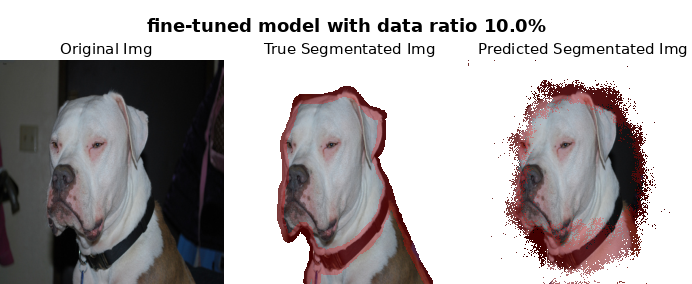

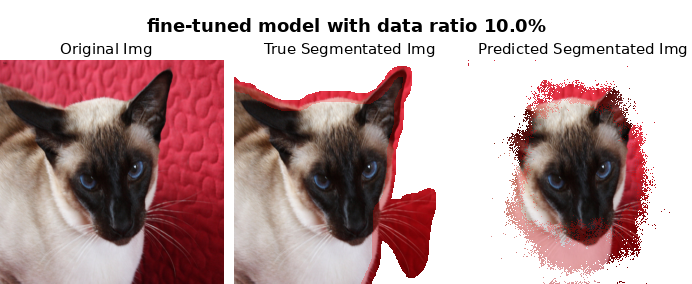

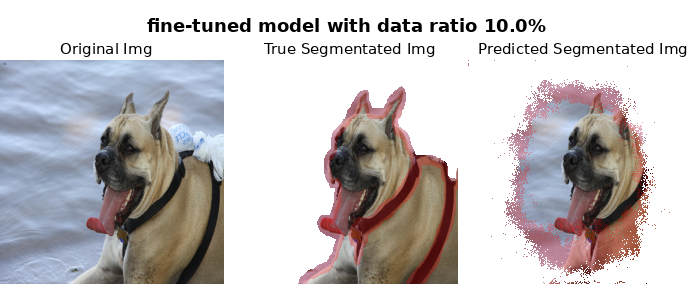


Fine-tuning Original dataset size: 3680
Fine-tuning Used dataset size: 1840 (50.0%)
Fine-tuning Training dataset size: 1472
Fine-tuning Testing dataset size: 368
Epoch 1 completed, Average Loss: 0.697, Duration: 14.55 seconds------------------------------------
Epoch 2 completed, Average Loss: 0.599, Duration: 14.36 seconds------------------------------------
Epoch 3 completed, Average Loss: 0.491, Duration: 14.67 seconds------------------------------------
Epoch 4 completed, Average Loss: 0.482, Duration: 14.47 seconds------------------------------------
Epoch 5 completed, Average Loss: 0.481, Duration: 14.45 seconds------------------------------------
Epoch 6 completed, Average Loss: 0.480, Duration: 14.31 seconds------------------------------------
Epoch 7 completed, Average Loss: 0.480, Duration: 14.42 seconds------------------------------------
Epoch 8 completed, Average Loss: 0.480, Duration: 14.28 seconds------------------------------------
Epoch 9 completed, Average Loss: 0.48

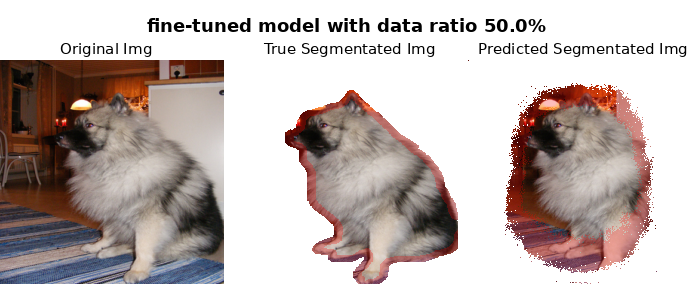

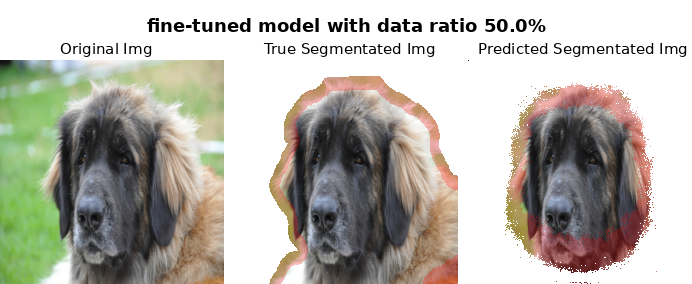

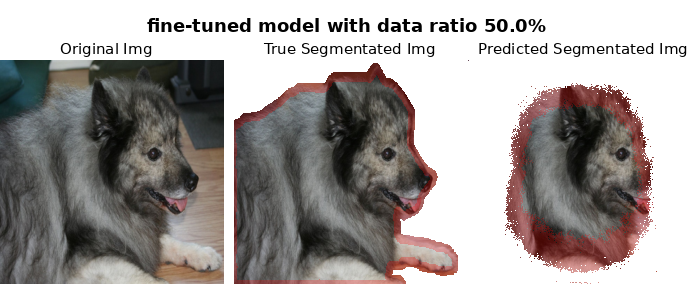


Fine-tuning Original dataset size: 3680
Fine-tuning Used dataset size: 3680 (100.0%)
Fine-tuning Training dataset size: 2944
Fine-tuning Testing dataset size: 736
Epoch 1 completed, Average Loss: 0.650, Duration: 29.05 seconds------------------------------------
Epoch 2 completed, Average Loss: 0.488, Duration: 28.91 seconds------------------------------------
Epoch 3 completed, Average Loss: 0.482, Duration: 28.92 seconds------------------------------------
Epoch 4 completed, Average Loss: 0.481, Duration: 28.85 seconds------------------------------------
Epoch 5 completed, Average Loss: 0.481, Duration: 28.92 seconds------------------------------------
Epoch 6 completed, Average Loss: 0.481, Duration: 29.09 seconds------------------------------------
Epoch 7 completed, Average Loss: 0.481, Duration: 29.43 seconds------------------------------------
Epoch 8 completed, Average Loss: 0.481, Duration: 28.88 seconds------------------------------------
Epoch 9 completed, Average Loss: 0.4

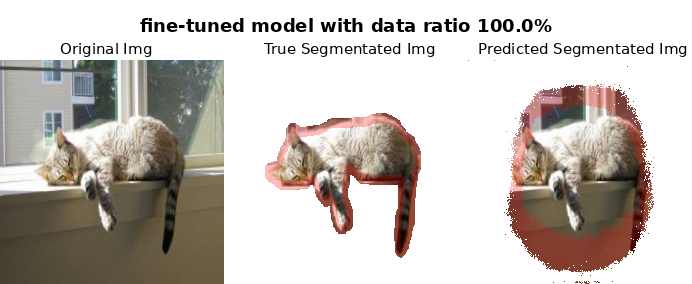

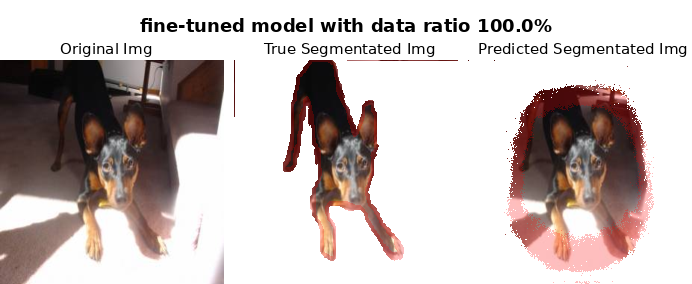

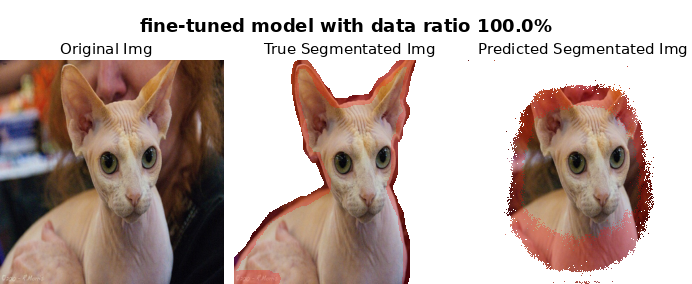

In [7]:
transform = Transform(image_size = dataset_config['image_size'])
full_dataset = torchvision.datasets.OxfordIIITPet(root='../datasets',
                        target_types='segmentation',
                        transforms=transform,
                        download=True)

# Function to perform fine-tuning
def fine_tune_model(data_ratio):

    # Define the size of training and testing datasets
    total_size = len(full_dataset)
    used_data_size = int(total_size * data_ratio)
    train_size = int(used_data_size * fine_tune_dataset_split['train_ratio'])
    test_size = used_data_size - train_size

    # Split the dataset
    indices = torch.randperm(total_size).tolist()
    used_indices = indices[:used_data_size]
    train_indices = used_indices[:train_size]
    test_indices = used_indices[train_size:]
    
    train_dataset = torch.utils.data.Subset(full_dataset, train_indices)
    test_dataset = torch.utils.data.Subset(full_dataset, test_indices)

    print(f"\nFine-tuning Original dataset size: {total_size}")
    print(f"Fine-tuning Used dataset size: {used_data_size} ({data_ratio*100}%)")
    print(f"Fine-tuning Training dataset size: {len(train_dataset)}")
    print(f"Fine-tuning Testing dataset size: {len(test_dataset)}")

    train_loader = DataLoader(train_dataset, batch_size=fine_tune_training_config['batch_size'], shuffle=fine_tune_training_config['shuffle_train'], drop_last=True)
    test_loader = DataLoader(test_dataset, batch_size=4, shuffle=fine_tune_training_config['shuffle_test'], drop_last=True)

    mask = torch.ones(size=(1, 3, 224, 224)).to(device)
    fine_model_with_pre = copy.deepcopy(pre_model).to(device)  # Use deepcopy to ensure that the weights of pre_model remain unchanged
    optimizer = optim.Adam(fine_model_with_pre.parameters(), lr=fine_tune_training_config['learning_rate'])

    # Fine-tuning the model
    for epoch in range(fine_tune_training_config['training_epochs']):
        start_time = time.time()
        fine_model_with_pre.train()
        total_loss = 0.0
        total_batches = 0
        for i, (x, y) in enumerate(train_loader):
            inputs, targets = x.to(device), y.to(device)
            optimizer.zero_grad()
            preds = fine_model_with_pre(inputs, mask)
            if preds.size(0) == inputs.size(0):
                batch_size = preds.shape[0]
                preds = preds.reshape(batch_size, 3, 224, 224)
                loss = dice_loss(preds, targets)
                accuracy = pixel_wise_accuracy(preds, targets)
                loss.backward()
                optimizer.step()

                # Accumulate loss
                total_loss += loss.item()
                total_batches += 1

                # Print batch loss
                # print(f'Epoch {epoch+1}, Batch {i+1}, Loss: {loss.item():.3f}, Accuracy: {accuracy:.3f}')

        average_loss = total_loss / total_batches if total_batches > 0 else 0
        end_time = time.time()
        epoch_duration = end_time - start_time
        print(f'Epoch {epoch+1} completed, Average Loss: {average_loss:.3f}, Duration: {epoch_duration:.2f} seconds------------------------------------')

    # Evaluate the performance
    evaluate_model_performance(fine_model_with_pre, test_loader, device, mask, f"fine-tuned model with data ratio {data_ratio * 100}%")

    test_visualization(fine_model_with_pre, test_loader, mask, device, f"fine-tuned model with data ratio {data_ratio * 100}%", "../images/compare_pretrained_model_finetuning_sizes")

    fine_model_with_pre.to('cpu')
    torch.cuda.empty_cache()  
    gc.collect()

# Iterate over different dataset sizes
for size in dataset_sizes:
    fine_tune_model(size)